# Objetivos da Replicação

O objetivo desta replicação é reproduzir e analisar, de forma comparativa, os resultados apresentados no artigo *“Analyzing Developer-ChatGPT Conversations for Software Refactoring: An Exploratory Study”*, publicado no contexto da conferência MSR’24, a partir de um conjunto de dados distinto, porém conceitualmente equivalente. Enquanto o estudo original utiliza um snapshot do dataset Dev-GPT datado de 14 de setembro de 2023, esta replicação se baseia em um arquivo CSV minerado contendo múltiplas fontes de dados, com foco específico no snapshot de 12 de outubro de 2023.

A replicação busca responder às mesmas questões de pesquisa definidas no estudo original, a saber:

- **(RQ1) Qual é a natureza das conversas entre desenvolvedores e o ChatGPT**.

- **(RQ2) Como o ChatGPT é usado para realizar refatoração de código**.

- **(RQ3) Em média, quantas solicitações
são necessárias para chegar a uma conclusão**.

Ao reproduzir essas questões em um contexto temporal posterior e com uma estratégia metodológica distinta, pretende-se avaliar a consistência dos achados originais e investigar possíveis mudanças no padrão de uso do ChatGPT por desenvolvedores ao longo do tempo.


Por fim, ao comparar os resultados obtidos com aqueles reportados no estudo original, esta replicação contribui para uma compreensão mais ampla da evolução do uso do ChatGPT em atividades de engenharia de software, especialmente no que diz respeito à refatoração de código, à complexidade das interações e ao papel do modelo como ferramenta de apoio no processo de desenvolvimento.


In [ ]:
#Importação das Bibliotecas
import pandas as pd       #Manipulação de Dados
import re        #Expressões Regulares (Regex)
import matplotlib.pyplot as plt     #Visualização de Dados

## Explorando DataFrame

In [ ]:
df_dev = pd.read_csv("base_minerada_msr24.csv")
df_dev.head()

,snapshot,origem,repo_url,chat_url,n_prompt,total_prompts_conversa,prompt_text,answer_text
0,20230727,hn,https://news.ycombinator.com/item?id=36862850,https://chat.openai.com/share/d6966012-0d96-45...,1,1,Write a training plan for a series of lessons ...,Learning Objectives:Understand the basics of P...
1,20230727,hn,https://news.ycombinator.com/item?id=36852545,https://chat.openai.com/share/983ebd1b-58a7-43...,1,12,nine hundred alda in meters. If you don't h...,"The distance of nine hundred alda, using the g..."
2,20230727,hn,https://news.ycombinator.com/item?id=36852545,https://chat.openai.com/share/983ebd1b-58a7-43...,2,12,I wouldn't have expected a fathom to be that u...,"Yes, you're correct that the term ""fathom"" is ..."
3,20230727,hn,https://news.ycombinator.com/item?id=36852545,https://chat.openai.com/share/983ebd1b-58a7-43...,3,12,what's the world record furthest sniper shot?,"As of my knowledge cutoff in September 2021, t..."
4,20230727,hn,https://news.ycombinator.com/item?id=36852545,https://chat.openai.com/share/983ebd1b-58a7-43...,4,12,"Yeah, so Jochi Kasar got a very significant % ...","Indeed, if the estimation of the alda we used ..."


O conjunto de dados utilizado nesta replicação contém **11.523 registros**, organizados em um DataFrame do Pandas com **8 colunas**. Cada registro representa uma interação individual entre desenvolvedores e o ChatGPT, permitindo análises em nível de prompt e de conversa.

 **Descrição das Colunas**
- **snapshot**: Identificador temporal da coleta dos dados.
- **origem**: Fonte da interação (ex.: repositórios do GitHub, fóruns).
- **repo_url**: URL do repositório de software associado.
- **chat_url**: Identificador que agrupa os prompts pertencentes à mesma conversa.
- **n_prompt**: Posição do prompt dentro da conversa.
- **total_prompts_conversa**: Número total de prompts na conversa.
- **prompt_text**: Texto do prompt enviado pelo desenvolvedor.
- **answer_text**: Resposta gerada pelo ChatGPT.

**Características dos Dados**
- **Colunas numéricas**: 3 (`int64`)
- **Colunas textuais**: 5 (`object`)
- **Valores ausentes**: 8 registros apenas em `prompt_text`

A estrutura do dataset é compacta e bem definida, sendo adequada para análises estatísticas e mineração de texto, além de permitir a replicação das questões de pesquisa **RQ1, RQ2 e RQ3**.

In [ ]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11523 entries, 0 to 11522
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   snapshot                11523 non-null  int64 
 1   origem                  11523 non-null  object
 2   repo_url                11523 non-null  object
 3   chat_url                11523 non-null  object
 4   n_prompt                11523 non-null  int64 
 5   total_prompts_conversa  11523 non-null  int64 
 6   prompt_text             11515 non-null  object
 7   answer_text             11523 non-null  object
dtypes: int64(3), object(5)
memory usage: 720.3+ KB


Distribuição das Fontes de Dados

A distribuição das conversas por origem indica que a maior parte dos registros provém de **issues** (3.726), seguida por **commits** (2.875) e discussões no **Hacker News** (2.859). Conversas associadas a **pull requests** representam 1.690 registros, enquanto **discussion** apresenta menor volume (373). Essa distribuição evidencia que o uso do ChatGPT está majoritariamente associado a contextos práticos de desenvolvimento e manutenção de software, como resolução de problemas e implementação de mudanças, o que está alinhado com o escopo das questões de pesquisa investigadas neste estudo.


In [ ]:
df_dev.value_counts("origem")

,count
origem,
issue,3726
commit,2875
hn,2859
pr,1690
discussion,373


Distribuição Temporal dos Dados

A distribuição dos registros por *snapshot* indica que a maior parte das interações foi coletada em **2023-10-12** (5.203 registros), seguida por **2023-07-27** (2.730). As demais coletas apresentam volumes progressivamente menores, com destaque para **2023-08-03** (914), **2023-08-10** (734) e **2023-09-14** (571).

Snapshots posteriores, como **2023-08-17** (476), **2023-08-24** (408), **2023-09-07** (284) e **2023-08-31** (203), representam parcelas menores do conjunto total. Essa distribuição evidencia uma concentração significativa de dados em períodos específicos, refletindo diferentes momentos de coleta e permitindo análises temporais sobre a evolução do uso do ChatGPT em contextos de desenvolvimento de software.

In [ ]:
df_dev.value_counts("snapshot")

,count
snapshot,
20231012,5203
20230727,2730
20230803,914
20230810,734
20230914,571
20230817,476
20230824,408
20230907,284
20230831,203


Análise Estatística

In [ ]:
df_dev.describe()

,snapshot,n_prompt,total_prompts_conversa
count,1.152300e+04,11523.000000,11523.000000
mean,2.023089e+07,10.098152,19.201597
std,1.203986e+02,18.796363,31.108467
min,2.023073e+07,1.000000,1.000000
25%,2.023080e+07,1.000000,2.000000
50%,2.023091e+07,3.000000,8.000000
75%,2.023101e+07,10.000000,23.000000
max,2.023101e+07,167.000000,167.000000


Valores Ausentes no Conjunto de Dados

A análise de valores ausentes indica que o conjunto de dados apresenta **completude quase total**. Apenas a coluna **prompt_text** contém valores ausentes, totalizando **8 registros**, enquanto todas as demais colunas não apresentam dados faltantes.

Dado o volume reduzido de valores ausentes em relação ao total de registros, essa limitação não compromete as análises realizadas e pode ser tratada de forma simples durante o pré-processamento, sem impacto significativo nos resultados das questões de pesquisa.

In [ ]:
df_dev.isnull().sum()

,0
snapshot,0
origem,0
repo_url,0
chat_url,0
n_prompt,0
total_prompts_conversa,0
prompt_text,8
answer_text,0


In [ ]:
#Eliminação de Valores NaNs
df_dev.dropna(inplace=True)

In [ ]:
#Visualização de Valores Duplicados
df_dev.duplicated().sum()

np.int64(0)

## Replicação do Artigo

In [ ]:
#Selecionando Apenas o Snapshot Alvo
df_dev_updated = df_dev[df_dev["snapshot"] == 20230914]
df_dev_updated.head()

,snapshot,origem,repo_url,chat_url,n_prompt,total_prompts_conversa,prompt_text,answer_text
5749,20230914,pr,https://github.com/mlc-ai/web-stable-diffusion...,https://chat.openai.com/share/a3f23f8c-935e-4b...,4,16,"I made a few changes, here is what it looks li...",To elevate the readability and visual structur...
5750,20230914,pr,https://github.com/mlc-ai/web-stable-diffusion...,https://chat.openai.com/share/a3f23f8c-935e-4b...,5,16,I think it need the LI to clear both because t...,"Ah, the ""Lego-stacking"" issue you're encounter..."
5751,20230914,pr,https://github.com/cataclysmbnteam/Cataclysm-B...,https://chat.openai.com/share/af7046b4-832d-46...,1,4,how do i open a url in windows 10 command-line...,To open a URL from the Windows Command Prompt ...
5752,20230914,pr,https://github.com/cataclysmbnteam/Cataclysm-B...,https://chat.openai.com/share/af7046b4-832d-46...,2,4,void open_url( const std::string &url )\n{\n ...,std::system on Windows generally uses cmd.exe ...
5753,20230914,pr,https://github.com/cataclysmbnteam/Cataclysm-B...,https://chat.openai.com/share/af7046b4-832d-46...,3,4,"will running \n```\nstart ""cataclysmbnteam/Cat...","No, running that command in CMD.exe will not o..."


## Recorte do Dataset e Comparação com o Estudo Original

Após o filtro do conjunto de dados para o snapshot **2023-09-14**, foram identificados **571 registros**, correspondentes a **190 conversas únicas**, considerando a URL de compartilhamento do ChatGPT (`chat_url`) como identificador de conversa. Cada registro representa um prompt individual dentro de uma interação, enquanto as conversas agregam múltiplos prompts associados a uma mesma sessão entre desenvolvedores e o ChatGPT.

No estudo original, os autores reportam a utilização de **1.246 registros**, correspondentes a **447 conversas únicas**, após a remoção de conversas duplicadas no mesmo snapshot temporal. Dessa forma, embora esta replicação utilize o mesmo recorte temporal do trabalho de referência, o subconjunto analisado apresenta **menor volume de dados**, o que permite uma comparação direta dos resultados, mantendo alinhamento metodológico, ao mesmo tempo em que explicita diferenças de escala entre os conjuntos analisados.



In [ ]:
#Calculando Número de Registros
n_registros = len(df_dev_updated)

#Calculando o Número de Conversas
n_conversas = df_dev_updated["chat_url"].nunique()


#Imprimindo os Resultados ( Número de Registros / Número de Conversas)
n_registros, n_conversas


(571, 190)

## RQ1 — Natureza das Conversas entre Desenvolvedores e o ChatGPT

A RQ1 investiga **quais tipos de tarefas de engenharia de software motivam as interações entre desenvolvedores e o ChatGPT**. O objetivo é identificar a natureza das conversas e verificar se a distribuição temática observada no estudo original se mantém nesta replicação, considerando o mesmo recorte temporal (snapshot 2023-09-14), porém com um subconjunto distinto de dados.

### Abordagem Metodológica

A análise é conduzida no **nível de conversa**, agregando múltiplos prompts associados a uma mesma `chat_url`. A classificação temática é realizada de forma **automática**, com base em regras e palavras-chave extraídas do conteúdo textual dos prompts e, quando necessário, das respostas.

As conversas são classificadas em categorias equivalentes às do estudo original:
* *Documentation*
* *Issue*
* *New Feature*
* *Configuration*
* *Test*
* *Refactoring*
* *Other*

### Etapas da Análise
- Agrupamento dos registros por `chat_url`;
- Análise do texto dos prompts (`prompt_text`);
- Classificação automática das conversas em categorias temáticas;
- Cálculo da frequência e proporção de cada categoria;
- Comparação qualitativa com os resultados do estudo original.

### Colunas Utilizadas
- `chat_url`
- `prompt_text`
- `answer_text` (uso complementar)

Nenhuma anotação manual é realizada; todas as categorias são **derivadas automaticamente** a partir do conteúdo textual.

### Resultado Esperado

Como resultado da RQ1, espera-se obter a **distribuição das conversas por categoria temática**, identificando os tipos de interação mais frequentes. Embora diferenças quantitativas sejam esperadas, a expectativa é observar padrões compatíveis com o estudo original, especialmente a predominância de *New Feature*, *Issue* e *Refactoring*.


In [ ]:
#Criando Cópia do DataFrame
df_rq1 = df_dev_updated.copy()

#### 1. Agregação por Conversa
Transformando o dataset no nível de prompt em um dataset no nível de conversa, juntando todos os prompts e respostas de uma mesma conversa em um único texto.

In [ ]:
# Agrupa todos os registros que pertencem à mesma conversa
df_rq1 = df_dev_updated.groupby("chat_url").agg({
    # Junta todos os prompts da conversa em um único texto ( remove NaN, garante string, concatena com espaço )
    "prompt_text": lambda x: " ".join(x.dropna().astype(str)),
    "answer_text": lambda x: " ".join(x.dropna().astype(str))
}).reset_index()


In [ ]:
#Visualizando o DataFrame
df_rq1.head()

,chat_url,prompt_text,answer_text
0,https://chat.openai.com/share/01cb28b9-dffa-44...,"You are AI Junior, you code like Donald Knuth....","[CODE_BLOCK_0] Sure, let's update the componen..."
1,https://chat.openai.com/share/03ce2877-4d85-4e...,Today when i check the github desktop of my we...,Having a large number of changed files in the ...
2,https://chat.openai.com/share/04313a49-1783-49...,Write a bash script with an array of text whic...,You can create a Bash script to achieve this b...
3,https://chat.openai.com/share/044c41a3-fbc5-49...,====\n\nText extracted from the Mind Mirror Ap...,Timothy Leary's Mind Mirror: A Brief OverviewI...
4,https://chat.openai.com/share/04d5f99e-7ef6-49...,The user is using a stylus to write text in th...,"Certainly, here's a script to group freedraw s..."


## RQ1 — Classificação Temática das Conversas (Categoria Dominante)

Este módulo implementa a **classificação temática automática das conversas** entre desenvolvedores e o ChatGPT, com base em um **sistema de pontuação (score)** por categoria. Para cada conversa, são contabilizados os matches de palavras-chave associadas a diferentes tipos de tarefas de engenharia de software. A categoria com maior pontuação é atribuída como dominante.

Caso nenhuma categoria apresente ocorrências no texto analisado, a conversa é classificada como **Other**.

### Estratégia de Classificação

A classificação segue os passos abaixo:

1. **Definição de palavras-chave por categoria**  
   Conjuntos de termos representativos são definidos manualmente para cada categoria temática.

2. **Compilação de expressões regulares (regex)**  
   As palavras-chave são convertidas em expressões regulares, utilizando limites de palavra (`\b`) para evitar correspondências acidentais e garantindo robustez na identificação dos termos.

3. **Cálculo de pontuação por categoria**  
   Para cada conversa, é contabilizado o número de ocorrências (matches) de cada categoria no texto agregado dos prompts.

4. **Seleção da categoria dominante**  
   A categoria com maior pontuação é atribuída à conversa. Se todas as categorias obtiverem pontuação zero, a conversa é classificada como **Other**.

### Unidade de Análise

A classificação é realizada no **nível de conversa**, considerando os prompts agregados associados a cada `chat_url`. O campo `prompt_text` é utilizado como fonte principal para inferir a intenção do desenvolvedor.

### Saídas Geradas

Após a aplicação do classificador, são adicionadas ao DataFrame as seguintes colunas:

- **category**: categoria temática dominante da conversa
- **category_scores**: dicionário com a pontuação obtida por cada categoria (opcional, utilizado para auditoria e validação)

Essa abordagem baseada em regras garante **transparência, reprodutibilidade e alinhamento conceitual** com o estudo original, sendo adequada para a replicação da RQ1.


In [ ]:
# ============================================================
# RQ1 — Classificação Temática por KeyWords (classificações)
# ============================================================

rq1_keywords = {
    "Documentation": [
        "documentation", "doc", "readme", "explain", "explanation",
        "how does", "what is", "describe", "tutorial"
    ],
    "Issue": [
        "error", "bug", "issue", "exception", "fail", "problem",
        "not working", "stack trace", "crash"
    ],
    "New Feature": [
        "implement", "create", "add", "build", "generate",
        "new feature", "develop", "write code"
    ],
    "Configuration": [
        "install", "setup", "configure", "config", "environment",
        "docker", "yaml", "path", "dependency"
    ],
    "Test": [
        "test", "unit test", "pytest", "jest", "mock",
        "coverage", "assert"
    ],
    "Refactoring": [
        "refactor", "clean code", "improve readability",
        "rename", "extract", "split", "restructure"
    ]
}

# ------------------------------------------------------------
# 1) Compilar regex por categoria (mais robusto que "in")
# - Usamos \b para evitar matches acidentais dentro de palavras
# - Para termos com espaço ("unit test"), mantemos a expressão
# ------------------------------------------------------------
compiled = {}
for cat, terms in rq1_keywords.items():
    patterns = []
    for t in terms:
        t_escaped = re.escape(t)
        if " " in t:  # expressão/frase
            patterns.append(t_escaped)
        else:         # palavra única (boundary)
            patterns.append(rf"\b{t_escaped}\b")
    compiled[cat] = re.compile("|".join(patterns), re.IGNORECASE)

# ------------------------------------------------------------
# 2) Função: calcula score por categoria e escolhe dominante
# - Retorna também o "scoreboard" (útil para auditoria)
# ------------------------------------------------------------
def classify_rq1_by_score(text: str):
    text = "" if pd.isna(text) else str(text)
    scores = {}

    for cat, rx in compiled.items():
        # count = quantos matches daquela categoria existem no texto
        scores[cat] = len(rx.findall(text))

    # pegar melhor categoria (maior score)
    best_cat = max(scores, key=scores.get)
    best_score = scores[best_cat]

    if best_score == 0:
        return "Other", scores
    return best_cat, scores

# ------------------------------------------------------------
# 3) Aplicar no seu df_rq1 (conversas agregadas)
# - Usamos prompt_text como fonte principal (intenção do dev)
# ------------------------------------------------------------
result = df_rq1["prompt_text"].apply(classify_rq1_by_score)
df_rq1["category"] = result.apply(lambda x: x[0])
df_rq1["category_scores"] = result.apply(lambda x: x[1])  # opcional (auditoria)

df_rq1.head()

,chat_url,prompt_text,answer_text,category,category_scores
0,https://chat.openai.com/share/01cb28b9-dffa-44...,"You are AI Junior, you code like Donald Knuth....","[CODE_BLOCK_0] Sure, let's update the componen...",New Feature,"{'Documentation': 0, 'Issue': 0, 'New Feature'..."
1,https://chat.openai.com/share/03ce2877-4d85-4e...,Today when i check the github desktop of my we...,Having a large number of changed files in the ...,Documentation,"{'Documentation': 1, 'Issue': 0, 'New Feature'..."
2,https://chat.openai.com/share/04313a49-1783-49...,Write a bash script with an array of text whic...,You can create a Bash script to achieve this b...,Configuration,"{'Documentation': 0, 'Issue': 0, 'New Feature'..."
3,https://chat.openai.com/share/044c41a3-fbc5-49...,====\n\nText extracted from the Mind Mirror Ap...,Timothy Leary's Mind Mirror: A Brief OverviewI...,Test,"{'Documentation': 0, 'Issue': 0, 'New Feature'..."
4,https://chat.openai.com/share/04d5f99e-7ef6-49...,The user is using a stylus to write text in th...,"Certainly, here's a script to group freedraw s...",Other,"{'Documentation': 0, 'Issue': 0, 'New Feature'..."


In [ ]:
#Salvando o DataFrame para Análise em Pares
df_rq1.to_excel(
    "df_rq1.xlsx",
    index=True
)

In [ ]:
#Abrindo o Documento Final ( Revisado)
df_rq1_manual = pd.read_csv("df_rq1_final_classification.csv", sep=";")
df_rq1_manual.head()

,Unnamed: 0,chat_url,prompt_text,answer_text,category,category_scores,final_category_en
0,0,https://chat.openai.com/share/01cb28b9-dffa-44...,"You are AI Junior, you code like Donald Knuth....","[CODE_BLOCK_0] Sure, let's update the componen...",New Feature,"{'Documentation': 0, 'Issue': 0, 'New Feature'...",New Feature
1,1,https://chat.openai.com/share/03ce2877-4d85-4e...,Today when i check the github desktop of my we...,Having a large number of changed files in the ...,Documentation,"{'Documentation': 1, 'Issue': 0, 'New Feature'...",Documentation
2,2,https://chat.openai.com/share/04313a49-1783-49...,Write a bash script with an array of text whic...,You can create a Bash script to achieve this b...,Configuration,"{'Documentation': 0, 'Issue': 0, 'New Feature'...",Configuration
3,3,https://chat.openai.com/share/044c41a3-fbc5-49...,NaN,Timothy Leary's Mind Mirror: A Brief OverviewI...,Test,"{'Documentation': 0, 'Issue': 0, 'New Feature'...",Other
4,4,https://chat.openai.com/share/04d5f99e-7ef6-49...,The user is using a stylus to write text in th...,"Certainly, here's a script to group freedraw s...",Other,"{'Documentation': 0, 'Issue': 0, 'New Feature'...",Other


## RQ1 — Distribuição Temática das Conversas

A análise da RQ1 revela que a maior parte das conversas entre desenvolvedores e o ChatGPT está associada à categoria **New Feature**, que representa **40,53%** do total. Esse resultado indica um uso predominante da ferramenta para apoio à implementação e desenvolvimento de novas funcionalidades.

A categoria **Other** corresponde a **23,16%** das conversas, refletindo interações que não se enquadram claramente nas categorias predefinidas ou que apresentam intenções mais genéricas. Em seguida, observam-se conversas relacionadas à **Issue** (**11,05%**), **Documentation** (**10,53%**) e **Configuration** (**10,00%**), evidenciando o uso do ChatGPT para resolução de problemas, compreensão de código e configuração de ambientes.

As categorias **Refactoring** (**3,68%**) e **Test** (**1,05%**) apresentam menor representatividade, indicando que tarefas relacionadas à melhoria estrutural do código e à escrita de testes são menos frequentes no conjunto de dados analisado.

De forma geral, a distribuição temática observada está alinhada com o estudo original, no qual interações voltadas à implementação de funcionalidades e resolução de problemas também se destacam como os principais contextos de uso do ChatGPT em engenharia de software.


In [ ]:
#Agrupando a Classificação Final
rq1_distribution = (
    df_rq1_manual["final_category_en"]
    .value_counts(normalize=True)
    .mul(100)
    .reset_index()
)

rq1_distribution.columns = ["Category", "Percentage (%)"]
rq1_distribution


,Category,Percentage (%)
0,New Feature,40.526316
1,Other,23.157895
2,Issue,11.052632
3,Documentation,10.526316
4,Configuration,10.000000
5,Refactoring,3.684211
6,Test,1.052632


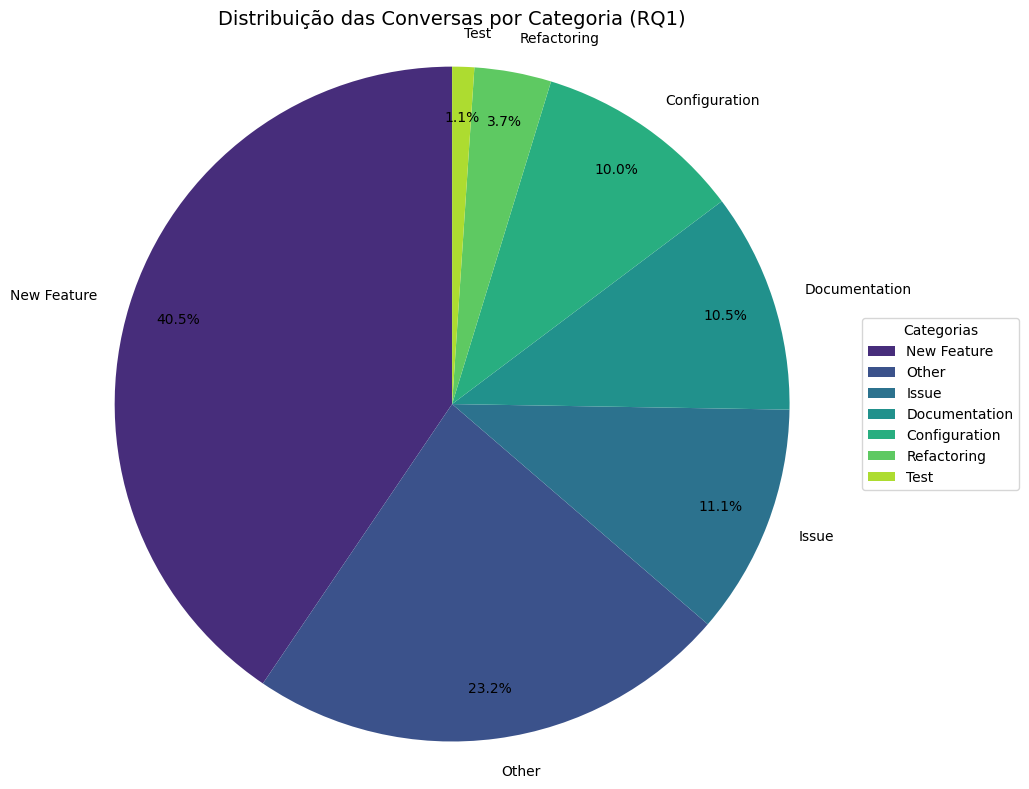

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Criando o gráfico de pizza
plt.figure(figsize=(10, 8))
plt.pie(
    rq1_distribution['Percentage (%)'],
    labels=rq1_distribution['Category'],
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('viridis', n_colors=len(rq1_distribution)),
    pctdistance=0.85 # Distância das porcentagens do centro
)
plt.title('Distribuição das Conversas por Categoria (RQ1)', fontsize=14)
plt.ylabel('')
plt.legend(title="Categorias", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal')
plt.tight_layout()
plt.show()

## RQ2 — Uso do ChatGPT em Atividades de Refatoração de Código

A RQ2 investiga **como o ChatGPT é utilizado por desenvolvedores em tarefas de refatoração de código**, com foco nos **padrões de solicitação adotados** durante essas interações. O objetivo é verificar se os padrões identificados no estudo original também se manifestam nesta replicação, considerando o mesmo recorte temporal (snapshot 2023-09-14).

### Unidade de Análise
- **Conversa** (`chat_url`), agregando todos os prompts associados a uma mesma interação.

### Abordagem Metodológica

A análise é conduzida em três etapas principais:

1. **Identificação das conversas de refatoração**  
   Seleção de conversas com indícios de refatoração a partir do conteúdo textual dos prompts.

2. **Classificação dos padrões de uso**  
   As conversas identificadas são classificadas em dois padrões, conforme definido no estudo original:
   - **Refatoração guiada**: o desenvolvedor fornece instruções explícitas sobre como o código deve ser modificado.
   - **Refatoração aberta**: o desenvolvedor solicita melhorias de forma genérica, delegando ao ChatGPT as decisões de refatoração.

3. **Análise da distribuição dos padrões**  
   Cálculo da proporção de cada padrão em relação ao total de conversas de refatoração.

### Colunas Utilizadas
- `chat_url`
- `prompt_text`
- `answer_text`
- `n_prompt`

Essas colunas permitem analisar tanto o conteúdo quanto a estrutura das interações relacionadas à refatoração.

### Estratégia de Classificação

Diferentemente do estudo original, que emprega anotação manual, esta replicação utiliza uma **abordagem automática baseada em regras e palavras-chave** para identificar conversas de refatoração e classificar os padrões de uso. Essa estratégia garante **transparência, reprodutibilidade e alinhamento conceitual** com o artigo de referência.

### Resultado Esperado

Como resultado da RQ2, espera-se obter a **distribuição das conversas de refatoração entre os padrões de refatoração guiada e refatoração aberta**, permitindo uma comparação qualitativa com os achados do estudo original.


In [ ]:
df_rq2 = df_dev_updated.copy()

## RQ2 — Fase 01: Identificação de Conversas Relacionadas à Refatoração (Mapping)

A Fase 01 da RQ2 tem como objetivo **identificar conversas candidatas a tarefas de refatoração de código** no conjunto de interações entre desenvolvedores e o ChatGPT. Essa etapa corresponde à fase de *mapping* descrita no artigo de referência e visa reduzir o espaço de busca para análises posteriores mais detalhadas.

### Unidade de Análise
- **Conversa** (`chat_url`), considerada como uma sequência de prompts associados a uma mesma interação.

### Estratégia de Identificação

A identificação de conversas relacionadas à refatoração é realizada por meio de uma **abordagem baseada em palavras-chave**, utilizando **29 stems de termos de refatoração** propostos por AlOmar et al. e reutilizados no estudo original.  
A busca é conduzida com **expressões regulares (regex)**, permitindo capturar variações morfológicas dos termos (por exemplo, *refactor*, *refactoring*, *refactored*).

Uma conversa é marcada como candidata à refatoração quando **ao menos um de seus prompts** apresenta correspondência com algum dos stems definidos.

### Procedimento
- Seleção do snapshot temporal analisado;
- Ordenação dos prompts por sequência temporal dentro de cada conversa;
- Aplicação das expressões regulares sobre o texto dos prompts;
- Marcação das conversas com indícios de refatoração;
- Agregação dos dados no nível de conversa, gerando:
  - um indicador binário de presença de refatoração (`has_refactoring`);
  - o texto agregado da conversa;
  - o número total de prompts por conversa.

### Resultado da Fase 01

O resultado desta fase é um **subconjunto de conversas candidatas à refatoração**. A estratégia adotada é **deliberadamente permissiva**, priorizando alto *recall*, o que implica a possível presença de falsos positivos. Esses casos são tratados nas etapas subsequentes da RQ2, conforme a metodologia do estudo original.

### Observação Metodológica

A Fase 01 não determina se uma conversa representa efetivamente uma refatoração de código, mas sim **identifica potenciais candidatos** para análise aprofundada, garantindo escalabilidade e alinhamento metodológico com o artigo de referência.


In [ ]:
#Dicionário das Palavras chaves
refactoring_keywords = [
    r"refactor", r"mov", r"split", r"fix", r"introduc", r"decompos", r"reorganiz",
    r"extract", r"merg", r"renam", r"chang", r"restructur", r"reformat", r"extend",
    r"remov", r"replac", r"rewrit", r"simplif", r"creat", r"improv", r"add", r"modif",
    r"enhanc", r"rework", r"inlin", r"redesign", r"cleanup", r"reduc", r"encapsulat"
]

pattern_refactor = re.compile(r"\b(" + "|".join(refactoring_keywords) + r")\w*\b", re.IGNORECASE)

# Indicador booleano de presença de termos de refatoração no prompt
df_rq2["is_refactoring_prompt"] = df_rq2["prompt_text"].fillna("").apply(
    lambda x: bool(pattern_refactor.search(x))
)
# Lista de hits por prompt (para aplicar critério forte depois)
df_rq2["refactor_hits"] = df_rq2["prompt_text"].fillna("").apply(
    lambda x: list(set(pattern_refactor.findall(x.lower())))
)


Para identificar conversas relacionadas à refatoração (RQ2), adotou-se uma abordagem baseada em palavras-chave e evidências estruturais. Primeiramente, foram detectadas ocorrências explícitas do termo “refactor”. Em seguida, foram considerados indicadores estruturais de refatoração, como “extract”, “rename”, “move” e “split”. Uma conversa foi classificada como candidata à refatoração se contivesse explicitamente o termo “refactor” ou pelo menos três indicadores estruturais simultaneamente. Aplicando esse critério, foram identificadas 51 conversas (26,84% do total), indicando que aproximadamente um quarto das interações analisadas envolvem tarefas de refatoraçã

In [ ]:
# Regex: "refactor*" explícito
pattern_refactor_word = re.compile(r"\brefactor\w*\b", re.IGNORECASE)

# Stems estruturais (indicadores mais fortes)
structural_stems = [
    "extract", "split", "renam", "mov", "inlin", "encapsulat",
    "restructur", "reformat", "cleanup", "decompos", "reorganiz"
]
pattern_structural = re.compile(r"\b(" + "|".join(structural_stems) + r")\w*\b", re.IGNORECASE)

# Agrega por conversa
conversations = (
    df_rq2.groupby("chat_url", as_index=False)
    .agg(
        all_prompts=("prompt_text", lambda x: " ".join(x.dropna().astype(str))),
        n_prompts=("prompt_text", "size"),
        hits=("refactor_hits", lambda col: sorted(set(h for hits in col for h in hits)))
    )
)

# Feature necessária (mantida)
conversations["n_unique_hits"] = conversations["hits"].apply(len)

# --- Séries temporárias (não viram colunas) ---
s_has_refactor_word = conversations["all_prompts"].apply(
    lambda t: bool(pattern_refactor_word.search(str(t)))
)

s_has_structural = conversations["all_prompts"].apply(
    lambda t: bool(pattern_structural.search(str(t)))
)

s_has_refactoring_strict = (
    s_has_refactor_word |
    ((conversations["n_unique_hits"] >= 3) & s_has_structural)
)

# Filtra candidatas sem criar colunas extras
refactoring_conversations = conversations[s_has_refactoring_strict].copy()

print("Total de conversas:", len(conversations))
print("Conversas candidatas a refatoração:", len(refactoring_conversations))
print("Percentual:", round(len(refactoring_conversations) / len(conversations) * 100, 2), "%")


Total de conversas: 190
Conversas candidatas a refatoração: 51
Percentual: 26.84 %


In [ ]:
refactoring_conversations.head()

,chat_url,all_prompts,n_prompts,hits,n_unique_hits
3,https://chat.openai.com/share/044c41a3-fbc5-49...,====\n\nText extracted from the Mind Mirror Ap...,1,"[chang, creat, enhanc, extract, modif]",5
8,https://chat.openai.com/share/09213749-12be-43...,"You are AI Junior, you code like Donald Knuth....",1,"[chang, creat, fix, remov, split]",5
12,https://chat.openai.com/share/0d4433c3-1173-4b...,"You are AI Junior, you code like Donald Knuth....",2,"[add, chang, creat, mov]",4
17,https://chat.openai.com/share/13ce58f0-a37b-47...,Refactor given component using functional comp...,4,"[add, extend, refactor]",3
19,https://chat.openai.com/share/186b240c-7246-47...,I have a server.js please refactor it\n\ncons...,2,"[creat, fix, refactor, replac]",4


Salvando o Dataframe para Análise Manual

In [ ]:
refactoring_conversations.to_excel(
    "df_rq2.xlsx",
    index=True
)


Após a Revisão manual, o integrante criou uma coluna chamada "manual_review" para marcar quais das 51 candidatas conversas são de fato de conversas de refatoração

**43 Conversas são de refatoração:  22,63%**

In [ ]:
df_rq2_atualizado = pd.read_excel('df_rq2_revisado.xlsx')
df_rq2_atualizado_manual_review = df_rq2_atualizado[["chat_url", "all_prompts", "n_prompts", "hits", "manual_review"]]
df_rq2_atualizado_manual_review.head()

,chat_url,all_prompts,n_prompts,hits,manual_review
0,https://chat.openai.com/share/044c41a3-fbc5-49...,NaN,1,"['chang', 'creat', 'enhanc', 'extract', 'modif']",False
1,https://chat.openai.com/share/09213749-12be-43...,"You are AI Junior, you code like Donald Knuth....",1,"['chang', 'creat', 'fix', 'remov', 'split']",True
2,https://chat.openai.com/share/0d4433c3-1173-4b...,"You are AI Junior, you code like Donald Knuth....",2,"['add', 'chang', 'creat', 'mov']",True
3,https://chat.openai.com/share/13ce58f0-a37b-47...,Refactor given component using functional comp...,4,"['add', 'extend', 'refactor']",True
4,https://chat.openai.com/share/186b240c-7246-47...,I have a server.js please refactor it\n\ncons...,2,"['creat', 'fix', 'refactor', 'replac']",True


In [ ]:
#Selecionando Apenas as Conversas Classificadas como True
df_rq2_atualizado_manual_review = df_rq2_atualizado_manual_review[df_rq2_atualizado_manual_review["manual_review"]]
df_rq2_atualizado_manual_review.head()

,chat_url,all_prompts,n_prompts,hits,manual_review
1,https://chat.openai.com/share/09213749-12be-43...,"You are AI Junior, you code like Donald Knuth....",1,"['chang', 'creat', 'fix', 'remov', 'split']",True
2,https://chat.openai.com/share/0d4433c3-1173-4b...,"You are AI Junior, you code like Donald Knuth....",2,"['add', 'chang', 'creat', 'mov']",True
3,https://chat.openai.com/share/13ce58f0-a37b-47...,Refactor given component using functional comp...,4,"['add', 'extend', 'refactor']",True
4,https://chat.openai.com/share/186b240c-7246-47...,I have a server.js please refactor it\n\ncons...,2,"['creat', 'fix', 'refactor', 'replac']",True
5,https://chat.openai.com/share/1beec591-c015-4d...,"You are AI Junior, you code like Donald Knuth....",1,"['add', 'chang', 'creat', 'remov', 'split']",True


In [ ]:
df_rq2_atualizado_manual_review['manual_review'].value_counts()

,count
manual_review,
True,43


In [ ]:
print(f'Conversas Classificadas como Reaftoração: {len(df_rq2_atualizado_manual_review)}')

Conversas Classificadas como Reaftoração: 43


In [ ]:
len(df_rq2_atualizado_manual_review)

43

In [ ]:
df_rq2_atualizado_manual_review.head()

,chat_url,all_prompts,n_prompts,hits,manual_review
1,https://chat.openai.com/share/09213749-12be-43...,"You are AI Junior, you code like Donald Knuth....",1,"['chang', 'creat', 'fix', 'remov', 'split']",True
2,https://chat.openai.com/share/0d4433c3-1173-4b...,"You are AI Junior, you code like Donald Knuth....",2,"['add', 'chang', 'creat', 'mov']",True
3,https://chat.openai.com/share/13ce58f0-a37b-47...,Refactor given component using functional comp...,4,"['add', 'extend', 'refactor']",True
4,https://chat.openai.com/share/186b240c-7246-47...,I have a server.js please refactor it\n\ncons...,2,"['creat', 'fix', 'refactor', 'replac']",True
5,https://chat.openai.com/share/1beec591-c015-4d...,"You are AI Junior, you code like Donald Knuth....",1,"['add', 'chang', 'creat', 'remov', 'split']",True


## 🧪 Estratégia de Classificação

A classificação entre **refatoração guiada** e **refatoração aberta** é realizada por meio de uma **análise textual baseada em regras**, aplicada ao texto agregado da conversa (`all_prompts`).

A heurística parte do seguinte princípio:

- Conversas que contêm **verbos de ação específicos e instruções explícitas** são classificadas como **refatoração guiada**;
- Conversas que apresentam **pedidos genéricos de melhoria**, sem detalhamento técnico, são classificadas como **refatoração aberta**.

Essa distinção operacional reflete diretamente o **nível de controle exercido pelo desenvolvedor** sobre o processo de refatoração.

---

## 🧩 Procedimento de Classificação

O procedimento adotado nesta fase pode ser resumido nos seguintes passos:

1. Seleção apenas das conversas confirmadas como refatoração real (`manual_review == True`);
2. Agregação completa dos prompts da conversa em um único texto (`all_prompts`);
3. Aplicação de regras linguísticas baseadas em padrões lexicais explícitos;
4. Atribuição de uma das duas classes:
   - `guided_refactoring`
   - `open_refactoring`

Cada conversa recebe **uma única classificação**, respeitando o caráter mutuamente exclusivo dos dois padrões.

---

## 📊 Saídas Geradas

Ao final da Fase 03, o dataset passa a conter:

- Uma coluna indicando o **tipo de refatoração**;
- A base necessária para:
  - cálculo da distribuição dos padrões;
  - comparação com os resultados do artigo original;
  - análise qualitativa do papel do ChatGPT em tarefas de refatoração.

---

## 📐 Considerações Metodológicas

A abordagem adotada nesta fase:

- privilegia **reprodutibilidade e transparência**;
- substitui a anotação manual por **regras explícitas e auditáveis**;
- mantém alinhamento conceitual com o estudo original, mesmo diante da ausência de critérios operacionais detalhados no artigo.

Essa estratégia permite investigar, de forma sistemática, **como o grau de direcionamento do desenvolvedor influencia o papel assumido pelo ChatGPT no processo de refatoração**.

---

## ✅ Conexão com a RQ2

A Fase 03 conclui a operacionalização da RQ2 ao transformar conversas de refatoração em **evidências classificadas**, possibilitando responder empiricamente:

> *De que forma o ChatGPT é utilizado para apoiar atividades de refatoração de código?*


In [ ]:
guided_keywords = [
    r"\brename\b", r"\bextract\b", r"\binline\b", r"\bmove\b", r"\bsplit\b", r"\bmerge\b",
    r"\breplace\b", r"\bdecompose\b", r"\bencapsulate\b", r"\bconsolidate\b",
    r"\brestructure\b", r"\breorganize\b",

    # padrões/princípios explícitos
    r"use .* pattern", r"apply .* pattern", r"refactor .* to .* pattern",
    r"follow .* principle", r"apply .* principle",

]

open_keywords = [
     r"\brefactor\b", r"refactor this", r"refactor the code", r"clean up", r"\bcleanup\b",
    r"make it better", r"make it cleaner", r"make it more readable", r"improve readability",
    r"improve maintainability", r"\boptimize\b", r"\bsimplify\b", r"\bpolish\b", r"\brefine\b",
    r"more elegant", r"tidy up"
]

pattern_guided = re.compile("|".join(guided_keywords), re.IGNORECASE)
pattern_open = re.compile("|".join(open_keywords), re.IGNORECASE)

def classify_refactoring(text: str) -> str:
    text = str(text)
    if pattern_guided.search(text):
        return "Refatoração Guiada"
    elif pattern_open.search(text):
        return "Refatoração Aberta"
    else:
        return "Não Classificada"

df_rq2_atualizado_manual_review["refactoring_pattern"] = (df_rq2_atualizado_manual_review["all_prompts"].apply(classify_refactoring)
)


In [ ]:
df_rq2_atualizado_manual_review.head()

,chat_url,all_prompts,n_prompts,hits,manual_review,refactoring_pattern
1,https://chat.openai.com/share/09213749-12be-43...,"You are AI Junior, you code like Donald Knuth....",1,"['chang', 'creat', 'fix', 'remov', 'split']",True,Refatoração Guiada
2,https://chat.openai.com/share/0d4433c3-1173-4b...,"You are AI Junior, you code like Donald Knuth....",2,"['add', 'chang', 'creat', 'mov']",True,Não Classificada
3,https://chat.openai.com/share/13ce58f0-a37b-47...,Refactor given component using functional comp...,4,"['add', 'extend', 'refactor']",True,Refatoração Aberta
4,https://chat.openai.com/share/186b240c-7246-47...,I have a server.js please refactor it\n\ncons...,2,"['creat', 'fix', 'refactor', 'replac']",True,Refatoração Guiada
5,https://chat.openai.com/share/1beec591-c015-4d...,"You are AI Junior, you code like Donald Knuth....",1,"['add', 'chang', 'creat', 'remov', 'split']",True,Refatoração Guiada


In [ ]:
# Distribuição de padrões de refatoração
pattern_distribution = (
    df_rq2_atualizado_manual_review["refactoring_pattern"]
    .value_counts()
    .reset_index()
)

pattern_distribution.columns = ["Padrão de Refatoração", "Quantidade"]
pattern_distribution["Percentual (%)"] = (
    pattern_distribution["Quantidade"] /
    pattern_distribution["Quantidade"].sum() * 100
)

pattern_distribution

,Padrão de Refatoração,Quantidade,Percentual (%)
0,Refatoração Guiada,29,67.441860
1,Não Classificada,8,18.604651
2,Refatoração Aberta,6,13.953488


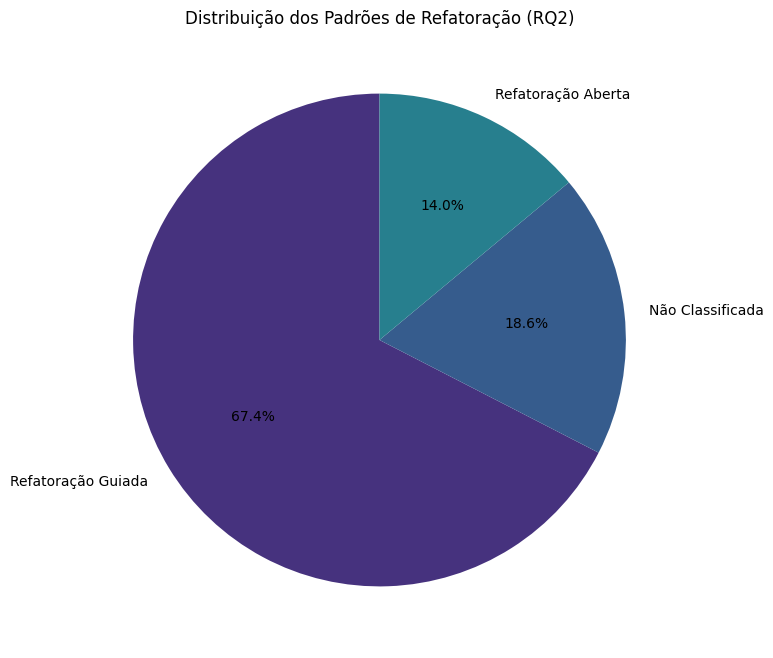

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))
plt.pie(pattern_distribution['Percentual (%)'],
        labels=pattern_distribution['Padrão de Refatoração'],
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('viridis'))
plt.title('Distribuição dos Padrões de Refatoração (RQ2)')
plt.ylabel('') # Remove default 'Percentual (%)' label
plt.show()

In [ ]:

df_rq2_atualizado_manual_review[df_rq2_atualizado_manual_review["refactoring_pattern"] == 'Não Classificada']

,chat_url,all_prompts,n_prompts,hits,manual_review,refactoring_pattern
2,https://chat.openai.com/share/0d4433c3-1173-4b...,"You are AI Junior, you code like Donald Knuth....",2,"['add', 'chang', 'creat', 'mov']",True,Não Classificada
11,https://chat.openai.com/share/3339cc3b-7975-47...,"B""H\nHow do i geth the position of an object i...",17,"['add', 'creat', 'mov', 'remov']",True,Não Classificada
13,https://chat.openai.com/share/692e1b13-0c07-41...,"You are AI Junior, you code like Donald Knuth....",1,"['chang', 'creat', 'extract', 'remov']",True,Não Classificada
15,https://chat.openai.com/share/6c10ce81-6d43-44...,"You are AI Junior, you code like Donald Knuth....",4,"['chang', 'creat', 'extract']",True,Não Classificada
23,https://chat.openai.com/share/944018ee-4f32-4f...,"You are AI Junior, you code like Donald Knuth....",2,"['add', 'chang', 'creat', 'split']",True,Não Classificada
34,https://chat.openai.com/share/b8e2bc63-1ea1-45...,I have a simple JavaScript library that I want...,1,"['add', 'creat', 'extract']",True,Não Classificada
46,https://chat.openai.com/share/e4394102-b1cf-41...,"You are AI Junior, you code like Donald Knuth....",2,"['add', 'chang', 'creat', 'extract']",True,Não Classificada
50,https://chat.openai.com/share/f4806cef-046b-44...,"You are AI Junior, you code like Donald Knuth....",3,"['chang', 'creat', 'fix', 'mov', 'remov']",True,Não Classificada


## RQ3 — Número Médio de Prompts por Conversa

A RQ3 investiga **quantos prompts, em média, são necessários para que uma conversa entre desenvolvedores e o ChatGPT chegue a uma conclusão**. Seguindo a interpretação do estudo original, a conclusão é definida como o **término da conversa**, isto é, o ponto em que a interação é encerrada após a troca de mensagens considerada suficiente pelo desenvolvedor.

### Unidade de Análise
- **Conversa** (`chat_url`), que agrupa todos os prompts trocados em uma mesma interação.

### Métrica Utilizada
- **Total de prompts por conversa**, calculado como o número de prompts trocados até o encerramento da interação.

### Abordagem Metodológica

- Não é aplicada deduplicação por `chat_url`, pois isso eliminaria prompts legítimos dentro da mesma conversa, comprometendo a métrica da RQ3.
- A deduplicação é realizada apenas para **linhas completamente duplicadas**, garantindo a remoção de registros redundantes sem perda de informação.
- O cálculo é feito por meio de `groupby("chat_url")` seguido do método `.size()`, que contabiliza corretamente o número total de prompts em cada conversa.

### Etapas da Análise
1. Remoção de registros duplicados (linha inteira);
2. Agrupamento das interações por `chat_url`;
3. Cálculo do número de prompts por conversa;
4. Cálculo da **média geral** de prompts por conversa;
5. Análise da **distribuição dos comprimentos das conversas** (média, percentis e dispersão).

### Objetivo Analítico

Essa abordagem permite estimar de forma precisa o **esforço interacional necessário para concluir uma tarefa com o ChatGPT**, mantendo consistência metodológica com o artigo original e garantindo validade estatística para a replicação da RQ3.


In [ ]:
df_rq3 = df_dev_updated.copy()

In [ ]:
# 1) Base de trabalho
df_rq3 = df_dev_updated.copy()

# 2) Remover apenas registros realmente duplicados (linha inteira)
df_rq3 = df_rq3.drop_duplicates().copy()

# 3) Construir DataFrame no nível de conversa e contar prompts reais
#    (cada linha = 1 prompt; então size() dá o número total de prompts na conversa)
df_conversas = (
    df_rq3
    .groupby(["chat_url", "origem"], as_index=False)
    .agg(total_prompts=("prompt_text", "size"))
)

# 4) Resultado principal (RQ3): média geral de prompts por conversa
media_geral = df_conversas["total_prompts"].mean()
print("RQ3 — Média geral de prompts por conversa:", round(media_geral, 2))



RQ3 — Média geral de prompts por conversa: 3.01


In [ ]:
# 5) Média por origem
media_por_origem = (
    df_conversas
    .groupby("origem")["total_prompts"]
    .mean()
    .reset_index(name="media_prompts")
    .sort_values("media_prompts", ascending=True)
)

print("\nRQ3 — Média de prompts por conversa (por origem):")
print(media_por_origem)




RQ3 — Média de prompts por conversa (por origem):
       origem  media_prompts
4          pr       2.000000
0      commit       2.542553
1  discussion       3.000000
3       issue       3.163636
2          hn       5.043478


In [ ]:
media_por_origem

,origem,media_prompts
4,pr,2.000000
0,commit,2.542553
1,discussion,3.000000
3,issue,3.163636
2,hn,5.043478
